# Calibrate mean and integrated intensity of a fluorescence marker versus concentration

## Requirements

- Images with different concentrations of the fluorescent tag with the concentration clearly specified in the image name

Prepare pure solutions of various concentrations of fluorescent tag in imaging media and collect images using parameters that are identical to those used for the experimental data collection (laser power, acquisition time, magnification, etc).

We recommend collecting images for 20-30 different concentrations, with 5-10 images per  concentration.

Clearly mark the concentration in the file or subfolder name in nM or uM. See [example_data/calibration](../../example_data/calibration) for examples of image naming. 

Note that the example images that we provide are cropped versions of the full images. You should use full images for calibration!

## Config

### The following code imports and declares functions used for the processing:

In [1]:
#################################
#  Don't modify the code below  #
#################################

import intake_io
import os
import re
import numpy as np
import pylab as plt
import seaborn as sns
from skimage import io
import pandas as pd
from tqdm import tqdm
from skimage.measure import regionprops_table

from am_utils.utils import walk_dir, combine_statistics

## Data & parameters

`input_dir`: folder with images to be analyzed

`output_dir`: folder to save results

`channel_name`: name of the fluorecent tag (e.g. "GFP")

## Specify data paths and parameters

In [2]:
input_dir = "../../example_data/calibration"
output_dir = "../../test_output/calibration"

channel_name = 'GFP'

### The following code lists all images in the input directory:

In [3]:
#################################
#  Don't modify the code below  #
#################################
samples = walk_dir(input_dir)

print(f'{len(samples)} images were found:')
print(np.array(samples))

4 images were found:
['../../example_data/calibration/05192021_GFPcalibration_1nM_-_Position_4_XY1621491830.tif'
 '../../example_data/calibration/05192021_GFPcalibration_5.62uM_-_Position_5_XY1621485379.tif'
 '../../example_data/calibration/05192021_GFPcalibration_31.6nM_-_Position_2_XY1621488646.tif'
 '../../example_data/calibration/05192021_GFPcalibration_100uM_-_Position_1_XY1621484495.tif']


### The following code loads a random image:

/research/sharedresources/cbi/public/conda_envs/punctatools/lib/python3.9/site-packages/scikit_image-0.19.0-py3.9-linux-x86_64.egg/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


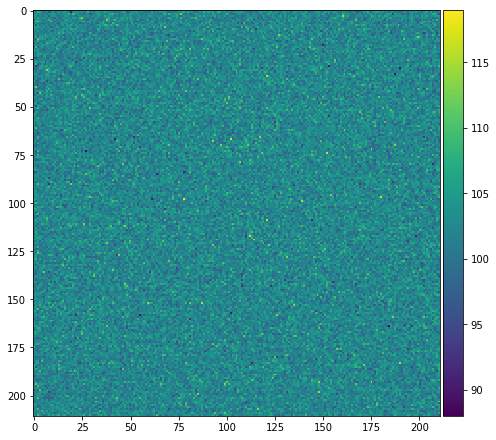

In [4]:
#################################
#  Don't modify the code below  #
#################################

sample = samples[np.random.randint(len(samples))]
dataset = intake_io.imload(sample)

if 'z' in dataset.dims:
    dataset = dataset.max('z')

plt.figure(figsize=(7, 7))
io.imshow(dataset['image'].data)

### The following code quantifies all input images:

In [5]:
%%time
#################################
#  Don't modify the code below  #
#################################

def quantify(sample, input_dir, output_dir, channel_name):
    dataset = intake_io.imload(sample)

    img = np.array(dataset['image'].data)

    df = pd.DataFrame(regionprops_table(label_image=np.ones_like(img),
                                        intensity_image=img,
                                        properties=['area', 'mean_intensity']))

    df = df.rename(columns={'area': 'image volume pix', 'mean_intensity':  rf'{channel_name} mean intensity per image'}) 
    df[rf'{channel_name} integrated intensity per image'] = df[rf'{channel_name} mean intensity per image'] * df['image volume pix']
      
    p_nm = re.compile(rf'([0-9]*\.?[0-9]+)nM')
    p_um = re.compile(rf'([0-9]*\.?[0-9]+)uM')
    
    fn = sample[len(input_dir)+1:]
    conc_nM = 0
    if len(p_nm.findall(fn)) > 0:
        conc_nM = float(p_nm.findall(fn)[0])
    if len(p_um.findall(fn)) > 0:
        conc_nM = float(p_um.findall(fn)[0]) * 1000
    
    df[rf'{channel_name} concentration nM'] = conc_nM
    df['Image name'] = fn
    fn_out = os.path.join(output_dir, fn.replace('.' + sample.split('.')[-1], '.csv'))
    
    # save the stats
    os.makedirs(os.path.dirname(fn_out), exist_ok=True)
    df.to_csv(fn_out, index=False)
    

for sample in tqdm(samples):
    quantify(sample, input_dir, output_dir, channel_name)

# combine the cell stats
print('Combining stats...')
combine_statistics(output_dir)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 151.67it/s]


Combining stats...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 699.75it/s]

CPU times: user 37.1 ms, sys: 4.96 ms, total: 42.1 ms
Wall time: 40.6 ms


In [6]:
df = pd.read_csv(output_dir.rstrip('/') + '.csv')
df

,GFP concentration nM,GFP integrated intensity per image,GFP mean intensity per image,Image name,image volume pix
0,1.0,8991762.0,100.983379,05192021_GFPcalibration_1nM_-_Position_4_XY162...,89042
1,5620.0,38477419.0,432.126626,05192021_GFPcalibration_5.62uM_-_Position_5_XY...,89042
2,31.6,9118962.0,102.411918,05192021_GFPcalibration_31.6nM_-_Position_2_XY...,89042
3,100000.0,469792452.0,5276.077042,05192021_GFPcalibration_100uM_-_Position_1_XY1...,89042


### The following code plots intensity versus concentration for sanity check

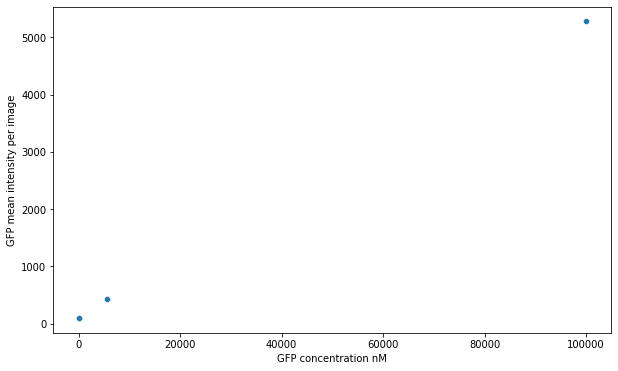

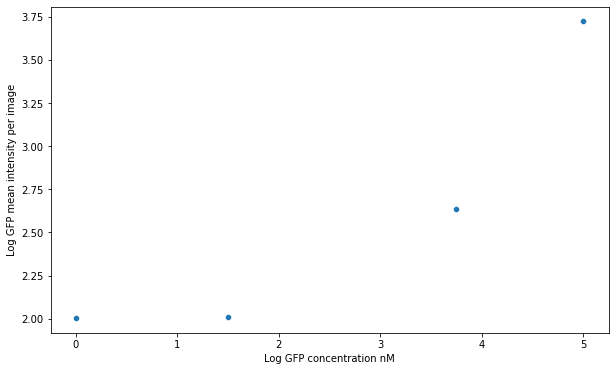

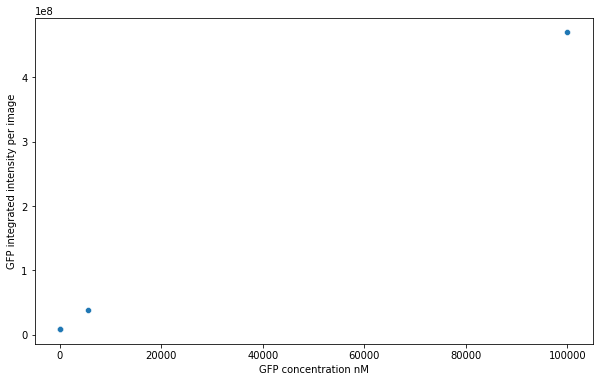

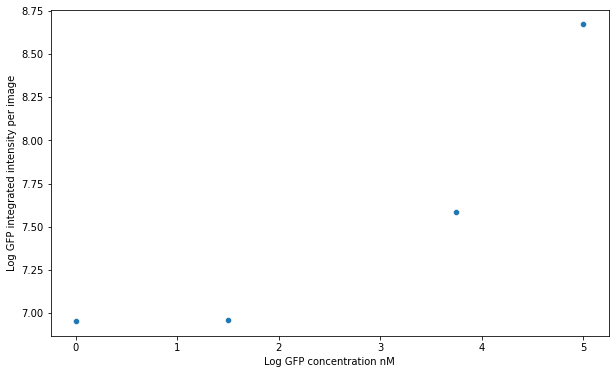

In [7]:
#################################
#  Don't modify the code below  #
#################################

for col in [rf'{channel_name} concentration nM', rf'{channel_name} mean intensity per image', rf'{channel_name} integrated intensity per image']:
    df['Log ' + col] = np.log10(df[col])
    
for col in [rf'{channel_name} mean intensity per image', rf'{channel_name} integrated intensity per image']:
    plt.figure(figsize=(10, 6))
    ax = sns.scatterplot(x = rf'{channel_name} concentration nM', y=col, data=df) 
    
    plt.figure(figsize=(10, 6))
    ax = sns.scatterplot(x = rf'Log {channel_name} concentration nM', y='Log ' + col, data=df) 
